In [2]:
  from analytics import TraceAnalysis
  ta = TraceAnalysis('results/20250622_155944')

  # Now just run SQL queries
  ta.sql("SELECT * FROM traces LIMIT 5")

,strategy_id,bar_idx,signal_value,price
0,0,5,0,521.25
1,0,71,1,520.21
2,0,78,0,519.13
3,0,79,-1,521.45
4,0,83,0,521.03


In [3]:
  df = ta.sql("""
      SELECT strategy_id, COUNT(*) as signal_count 
      FROM traces 
      GROUP BY strategy_id 
      ORDER BY signal_count DESC
  """)
  df.head(10)

,strategy_id,signal_count
0,1,3481
1,0,3262
2,2,3261
3,3,2826
4,7,2337
5,8,2326
6,4,2305
7,6,2107
8,9,2073
9,13,1781


<Axes: xlabel='strategy_id'>

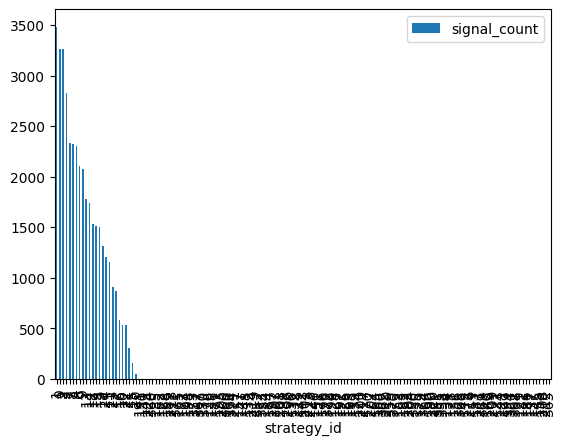

In [5]:
df.plot.bar(x='strategy_id', y='signal_count')

In [6]:
df

,strategy_id,signal_count
0,1,3481
1,0,3262
2,2,3261
3,3,2826
4,7,2337
...,...,...
145,145,1
146,158,1
147,208,1
148,212,1


In [7]:
  ta.sql("""
      WITH signal_changes AS (
          SELECT 
              strategy_id,
              bar_idx,
              signal_value,
              price,
              LAG(signal_value) OVER (PARTITION BY strategy_id ORDER BY bar_idx) as prev_signal,
              LAG(price) OVER (PARTITION BY strategy_id ORDER BY bar_idx) as prev_price
          FROM traces
      ),
      trades AS (
          -- Entry: signal goes from 0 to non-zero
          -- Exit: signal goes from non-zero to 0
          SELECT 
              strategy_id,
              SUM(CASE 
                  WHEN signal_value = 0 AND prev_signal != 0 THEN
                      -- Exit trade: calculate return
                      (price - prev_price) / prev_price * prev_signal
                  ELSE 0
              END) as total_return,
              COUNT(CASE WHEN signal_value = 0 AND prev_signal != 0 THEN 1 END) as num_trades
          FROM signal_changes
          WHERE prev_signal IS NOT NULL
          GROUP BY strategy_id
      )
      SELECT 
          strategy_id,
          num_trades,
          total_return,
          total_return / num_trades as avg_return_per_trade
      FROM trades
      WHERE num_trades > 20  -- Minimum trades for reliability
      ORDER BY total_return DESC
      LIMIT 20
  """)


,strategy_id,num_trades,total_return,avg_return_per_trade
0,21,151,0.011630,7.702291e-05
1,20,23,0.009432,4.100733e-04
2,5,748,0.008480,1.133650e-05
3,10,267,0.003447,1.290869e-05
4,24,600,0.002437,4.061573e-06
5,15,80,0.000422,5.277286e-06
6,22,264,0.000041,1.534509e-07
7,16,293,-0.004331,-1.478095e-05
8,12,765,-0.010337,-1.351190e-05
9,23,456,-0.011827,-2.593560e-05
